### Pearson相关系数
使用cor.test函数，分析这150条样本中花萼长度与花瓣长度的相关性，即计算出两个变量的Pearson相关系数即可

In [1]:
import pandas as pd
from scipy import stats
iris = pd.read_csv("http://image.cador.cn/data/iris.csv")
stats.pearsonr(iris['Sepal.Length'], iris['Petal.Length'])

(0.8717537758865831, 1.0386674194498099e-47)

Pearson相关系数虽然简单好用，但是它也有缺点，就是只对线性关系敏感，如果两变量是非线性关系，即使它们之间存在一一对应的关系，也会导致计算的结果趋近于0

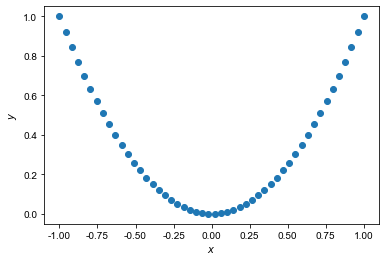

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.rcParams['font.family'] = 'Arial Unicode MS'
x=np.linspace(-1,1,50)
y=x**2
plt.plot(x,y,'o')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [3]:
stats.pearsonr(x, y)

(-1.6653345369377348e-16, 0.9999999999999966)

### 距离相关系数
使用scipy库中spatial.distanc模块的correlation函数，针对Pearson相关系数分析非线性的情况再做一次验证

In [4]:
from scipy.spatial.distance import correlation as dcor
dcor(x,y)

1.0000000000000002

### 单因素方差分析
下面使用statsmodels库中的stats.anova模块里面的anova_lm函数来实现单因素方差分析

并用iris数据集中的Species作为因素，Sepal.Width作为观测值。

In [5]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
iris = pd.read_csv("http://image.cador.cn/data/iris.csv")
iris.columns = ['_'.join(x.split('.')) for x in iris.columns]
anova_lm(ols('Sepal_Width~C(Species)', iris).fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(Species),2.0,11.344933,5.672467,49.16004,4.492017e-17
Residual,147.0,16.962000,0.115388,NaN,NaN


### 信息增益
使用Python编写离散化函数disc返回数值变量的二元分类值

In [6]:
import numpy as np
def gains(u, v):
    ent_u = [np.sum([p*np.log2(1/p) for p in ct/np.sum(ct)]) for ct in [np.unique(u,return_counts=True)[1]]][0]
    v_id,v_ct = np.unique(v,return_counts=True)
    ent_u_m = [np.sum([p*np.log2(1/p) for p in ct/np.sum(ct)]) for ct in [np.unique(u[v==m],return_counts=True)[1] for m in v_id]]
    return ent_u - np.sum(np.array(ent_u_m)*(v_ct/np.sum(v_ct)))

def disc(u, x):
    sorted_x = np.sort(x)
    max_gains, max_tmp = 0, None
    for e in sorted_x:
        tmp = np.zeros(len(x))
        tmp[x>e]=1
        tmp_gain = gains(u,tmp)
        if tmp_gain > max_gains:
            max_gains,max_tmp  = tmp_gain, tmp
    return max_tmp

使用disc函数对iris的数值型数据进行离散化处理

In [7]:
import pandas as pd
iris = pd.read_csv("http://image.cador.cn/data/iris.csv")
for col in iris.columns[0:-1]:
    iris[col] = disc(iris.Species,iris[col]).astype("int")
iris.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,0,1,0,0,setosa
1,0,0,0,0,setosa
2,0,0,0,0,setosa
3,0,0,0,0,setosa
4,0,1,0,0,setosa


基于gains函数来计算给定U和S1的信息增益

In [8]:
iris.columns=["S1","S2","P1","P2","Species"]
gains(iris['Species'],iris['S1'])

0.5572326878069265

使用自定义函数gains依次计算S2、P1、P2的信息增益

In [9]:
gains(iris['Species'],iris['S2'])

0.28312598916883114

In [10]:
gains(iris['Species'],iris['P1'])

0.9182958340544892

In [11]:
gains(iris['Species'],iris['P2'])

0.9182958340544892

使用Python自定义求解信息增益率的函数gainR，并将P2替换成全不相同的类别变量，并计算各输入变量的信息增益与信息增益率

In [12]:
def gainsR(u,v):
    ent_v = [np.sum([p*np.log2(1/p) for p in ct/np.sum(ct)]) for ct in [np.unique(v,return_counts=True)[1]]][0]
    return gains(u,v)/ent_v

iris['P2']=range(iris.shape[0])
# 计算信息增益，并排序
gains(iris['Species'],iris['S1'])

0.5572326878069265

In [13]:
gains(iris['Species'],iris['S2'])

0.28312598916883114

In [14]:
gains(iris['Species'],iris['P1'])

0.9182958340544892

In [15]:
gains(iris['Species'],iris['P2'])

1.5849625007211559

重要性次序为：P2 > P1 > S1 > S2

In [16]:
# 计算信息增益率，并排序
gainsR(iris['Species'],iris['S1'])

0.5762983610929974

In [17]:
gainsR(iris['Species'],iris['S2'])

0.35129384185463564

In [18]:
gainsR(iris['Species'],iris['P1'])

0.9999999999999999

In [19]:
gainsR(iris['Species'],iris['P2'])

0.21925608713979675

重要性次序为：P1 > S1 > S2 > P2

### 卡方检验
使用python中的scipy.stats模块下的chi2_contingency函数进行卡方检验，同样对离散化的iris数据集，分析Sepal.Width对Species的影响

In [20]:
from  scipy.stats import chi2_contingency
import numpy as np
import pandas as pd
iris = pd.read_csv("http://image.cador.cn/data/iris.csv")
for col in iris.columns[0:-1]:
    iris[col] = disc(iris.Species,iris[col]).astype("int")
iris['D']=1
chi_data = np.array(iris.pivot_table(values='D', index='Sepal.Width', columns='Species',aggfunc='sum'))
chi = chi2_contingency(chi_data)
print('chisq-statistic=%.4f, p-value=%.4f, df=%i expected_frep=%s'%chi)

chisq-statistic=57.1155, p-value=0.0000, df=2 expected_frep=[[37.66666667 37.66666667 37.66666667]
 [12.33333333 12.33333333 12.33333333]]
